# Adversarial Patches
### Sizhe Chen

In [5]:
import os
import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import transforms, models
import torchvision.transforms.functional as TF

In [6]:
# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [8]:
from torchvision import models, transforms

model = models.resnet34(pretrained=True).to(device)
model.eval()

# Define preprocess manually
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Load imagenet class names
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

print("Loaded", len(classes), "ImageNet classes.")
print("Example:", classes[:10])  # just to check

Loaded 1000 ImageNet classes.
Example: ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


In [11]:
def find_classes(keyword):
    return [(i, c) for i, c in enumerate(classes) if keyword.lower() in c.lower()]


# Example: search for 'toaster'
print(find_classes("toaster"))
# Choose a class name (exact or substring)
target_name = "toaster"  # change to the class you want
candidates = find_classes(target_name)
if not candidates:
    raise ValueError(f"No matches for '{target_name}' — try another keyword")
target_idx = candidates[0][0]
print("Using target index:", target_idx, "=>", classes[target_idx])

[(859, 'toaster')]
Using target index: 859 => toaster


In [12]:
# Load pretrained ResNet34 (works on all versions)
model = models.resnet34(pretrained=True).to(device).eval()

# Define ImageNet normalization manually
preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define mean/std tensors for denormalization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)


def denormalize(tensor):
    """Convert normalized tensor -> [0,1]"""
    t = tensor.clone().cpu()
    t = t * std + mean
    return torch.clamp(t, 0, 1)


def show_tensor(tensor, title=None):
    """Quick helper to show a tensor image"""
    img = TF.to_pil_image(denormalize(tensor))
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

Found images: 5


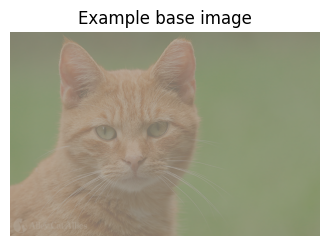

In [13]:
from glob import glob

# change path if necessary
image_folder = "data/images"  # create this folder and put example images in it
os.makedirs(image_folder, exist_ok=True)

# show files
image_paths = sorted(glob(os.path.join(image_folder, "*.*")))
print("Found images:", len(image_paths))
if len(image_paths) == 0:
    print("No images found. Place some JPG/PNG images in 'data/images' and re-run.")
else:
    # load as tensors (unnormalized) in range [0,1], size we'll keep flexible for augmentation
    def load_img_to_tensor(path):
        pil = Image.open(path).convert("RGB")
        t = TF.to_tensor(pil)  # C x H x W in [0,1]
        return t

    images_list = [load_img_to_tensor(p) for p in image_paths]
    # show first image
    show_tensor(images_list[0], title="Example base image")

In [16]:
def place_patch_on_image(img_tensor, patch_tensor, x, y):
    """
    img_tensor: C x H x W in [0,1]
    patch_tensor: C x ph x pw in [0,1]
    place so patch covers [y:y+ph, x:x+pw]
    returns patched image tensor (C x H x W)
    """
    img = img_tensor.clone()
    _, H, W = img.shape
    _, ph, pw = patch_tensor.shape
    # safety: if patch wider than image, resize patch
    if pw > W or ph > H:
        patch_tensor = TF.resize(patch_tensor, [min(ph, H), min(pw, W)])
        _, ph, pw = patch_tensor.shape
    img[:, y : y + ph, x : x + pw] = patch_tensor
    return img


def random_place_coords(img, patch):
    _, H, W = img.shape
    _, ph, pw = patch.shape
    max_x = max(0, W - pw)
    max_y = max(0, H - ph)
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    return x, y


def augment_image_and_patch(img, patch):
    """applies random brightness/contrast and random placement & small rotation/scale to patch"""
    # random small rotation/scale for patch
    ph, pw = patch.shape[1], patch.shape[2]
    # randomly scale between 0.8-1.2
    scale = random.uniform(0.85, 1.15)
    new_ph = max(1, int(ph * scale))
    new_pw = max(1, int(pw * scale))
    p = TF.resize(patch, [new_ph, new_pw])
    # maybe rotate a little
    angle = random.uniform(-15, 15)
    p = TF.rotate(p, angle)
    # choose random place
    x, y = random_place_coords(img, p)
    # maybe jitter image brightness/contrast slightly
    img_aug = TF.adjust_brightness(img, random.uniform(0.9, 1.1))
    img_aug = TF.adjust_contrast(img_aug, random.uniform(0.9, 1.1))
    out = place_patch_on_image(img_aug, p, x, y)
    return out

In [18]:
# hyperparams
patch_size_pixels = 160  # change to 160/300 depending on desired print resolution
num_epochs = 400
lr = 0.3
steps_per_epoch = max(1, len(images_list))  # number of images to sample per epoch
tv_weight = 1e-3

# initialize patch as logits (unbounded), we'll convert via sigmoid during usage
patch_logits = torch.randn(
    3, patch_size_pixels, patch_size_pixels, device=device, requires_grad=True
)
optimizer = torch.optim.Adam([patch_logits], lr=lr)

target = target_idx

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(steps_per_epoch):
        img = images_list[i % len(images_list)].to(device)  # CxHxW in [0,1]
        optimizer.zero_grad()
        patch = torch.sigmoid(patch_logits)  # 0..1
        patched_img = augment_image_and_patch(img, patch)  # CxH'xW' (same H,W as img)
        # resize to model input size and normalize using preprocess (uses PIL transforms)
        pil = TF.to_pil_image(patched_img.cpu())
        inp = preprocess(pil).unsqueeze(0).to(device)  # 1x3x224x224 normalized
        out = model(inp)  # 1x1000 logits
        probs = F.softmax(out, dim=1)[0]
        loss_target = -torch.log(probs[target] + 1e-8)
        # total variation for smoothness
        tv = torch.sum(torch.abs(patch[:, :, :-1] - patch[:, :, 1:])) + torch.sum(
            torch.abs(patch[:, :-1, :] - patch[:, 1:, :])
        )
        loss = loss_target + tv_weight * tv
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            # quick evaluation on first image
            patch = torch.sigmoid(patch_logits)
            sample_pat_img = augment_image_and_patch(images_list[0].to(device), patch)
            inp = (
                preprocess(TF.to_pil_image(sample_pat_img.cpu()))
                .unsqueeze(0)
                .to(device)
            )
            out = model(inp)
            probs = F.softmax(out, dim=1)[0]
            top5 = torch.topk(probs, 5)
            print(
                f"Epoch {epoch+1}/{num_epochs} avg_loss={epoch_loss/steps_per_epoch:.3f} top1={classes[top5.indices[0]]} prob={top5.values[0]:.3f}"
            )

Epoch 1/400 avg_loss=35.289 top1=tiger cat prob=0.789
Epoch 10/400 avg_loss=12.280 top1=tiger cat prob=0.768
Epoch 20/400 avg_loss=12.644 top1=tiger cat prob=0.798
Epoch 30/400 avg_loss=12.254 top1=tiger cat prob=0.606
Epoch 40/400 avg_loss=12.838 top1=tiger cat prob=0.812
Epoch 50/400 avg_loss=12.350 top1=tiger cat prob=0.760
Epoch 60/400 avg_loss=12.504 top1=tiger cat prob=0.706
Epoch 70/400 avg_loss=13.061 top1=tiger cat prob=0.849
Epoch 80/400 avg_loss=12.620 top1=tiger cat prob=0.779
Epoch 90/400 avg_loss=12.079 top1=tiger cat prob=0.780
Epoch 100/400 avg_loss=11.381 top1=tiger cat prob=0.723
Epoch 110/400 avg_loss=12.764 top1=tiger cat prob=0.917
Epoch 120/400 avg_loss=12.476 top1=tiger cat prob=0.763
Epoch 130/400 avg_loss=12.640 top1=tiger cat prob=0.814
Epoch 140/400 avg_loss=12.566 top1=tiger cat prob=0.851
Epoch 150/400 avg_loss=12.547 top1=tiger cat prob=0.878
Epoch 160/400 avg_loss=13.471 top1=tiger cat prob=0.807
Epoch 170/400 avg_loss=12.802 top1=tiger cat prob=0.830
Epo

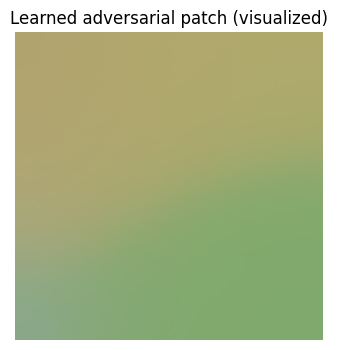

Saved patch to learned_patch.png


In [19]:
# save patch as PNG for printing
with torch.no_grad():
    learned_patch = torch.sigmoid(patch_logits).cpu()  # C x ph x pw in [0,1]
    # show it
    show_tensor(learned_patch, title="Learned adversarial patch (visualized)")

    # convert to PIL and save at high resolution; choose DPI when printing
    pil_patch = TF.to_pil_image(learned_patch)
    save_path = "learned_patch.png"
    pil_patch.save(save_path)
    print("Saved patch to", save_path)

File: data/images/FELV-cat.jpg
Before: [(282, 0.8358200192451477, 'tiger cat'), (281, 0.13175825774669647, 'tabby'), (285, 0.016876187175512314, 'Egyptian cat'), (287, 0.003309746040031314, 'lynx'), (722, 0.0029103525448590517, 'ping-pong ball')]
After : [(282, 0.8431816101074219, 'tiger cat'), (281, 0.12850455939769745, 'tabby'), (285, 0.00909635704010725, 'Egyptian cat'), (722, 0.00389328645542264, 'ping-pong ball'), (478, 0.002963189734145999, 'carton')]


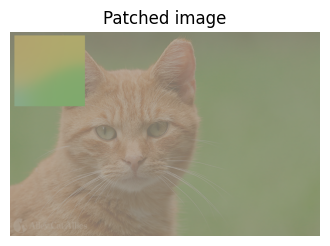

File: data/images/Red_Apple.jpg
Before: [(957, 0.7566825151443481, 'pomegranate'), (948, 0.066740483045578, 'Granny Smith'), (950, 0.05123782530426979, 'orange'), (954, 0.05047690123319626, 'banana'), (952, 0.02370441146194935, 'fig')]
After : [(957, 0.6819006204605103, 'pomegranate'), (948, 0.09876314550638199, 'Granny Smith'), (950, 0.0634818896651268, 'orange'), (954, 0.06317978352308273, 'banana'), (952, 0.027264216914772987, 'fig')]


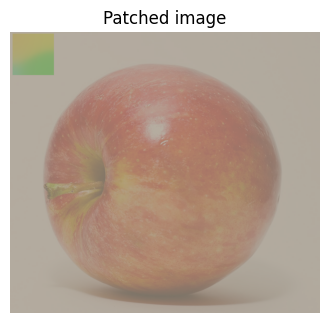

File: data/images/baby-duck-lossy.jpeg
Before: [(99, 0.23956981301307678, 'goose'), (97, 0.18128538131713867, 'drake'), (8, 0.09554034471511841, 'hen'), (356, 0.05709127336740494, 'weasel'), (98, 0.05592571198940277, 'red-breasted merganser')]
After : [(99, 0.2827184200286865, 'goose'), (97, 0.22126813232898712, 'drake'), (8, 0.09486639499664307, 'hen'), (356, 0.03990078344941139, 'weasel'), (98, 0.03932584449648857, 'red-breasted merganser')]


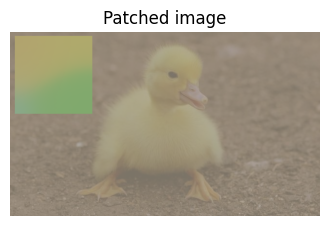

File: data/images/sunday-afternoons-havana-hat-hat.jpg
Before: [(808, 0.7589975595474243, 'sombrero'), (515, 0.24017632007598877, 'cowboy hat'), (855, 0.0007122574606910348, 'thimble'), (828, 3.182334694429301e-05, 'strainer'), (650, 2.1480393115780316e-05, 'microphone')]
After : [(808, 0.7268738746643066, 'sombrero'), (515, 0.272470623254776, 'cowboy hat'), (855, 0.0005303015350364149, 'thimble'), (828, 4.170090323896147e-05, 'strainer'), (650, 1.5747880752314813e-05, 'microphone')]


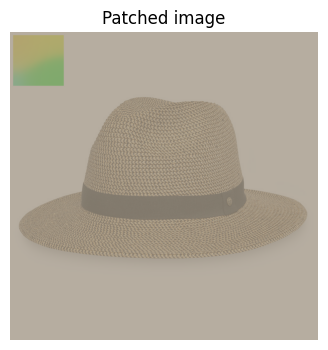

File: data/images/下载.jpeg
Before: [(898, 0.5951994061470032, 'water bottle'), (680, 0.3438654839992523, 'nipple'), (691, 0.02283462882041931, 'oxygen mask'), (737, 0.012106119655072689, 'pop bottle'), (899, 0.006906554102897644, 'water jug')]
After : [(898, 0.2717558443546295, 'water bottle'), (650, 0.06065942719578743, 'microphone'), (626, 0.05535321310162544, 'lighter'), (737, 0.05462793633341789, 'pop bottle'), (680, 0.05374952405691147, 'nipple')]


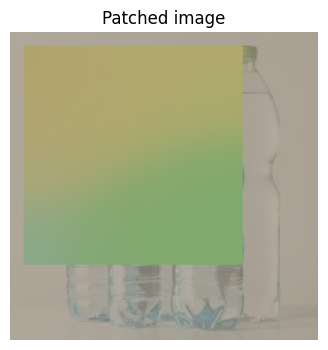

In [20]:
def predict_tensor(img_tensor, k=5):
    pil = TF.to_pil_image(img_tensor.cpu())
    inp = preprocess(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(inp)
        probs = F.softmax(out, dim=1)[0]
    topk = torch.topk(probs, k)
    return [
        (int(idx), float(prob), classes[int(idx)])
        for prob, idx in zip(topk.values, topk.indices)
    ]


# test on images_list
with torch.no_grad():
    patch = torch.sigmoid(patch_logits).cpu()
    for pth in image_paths[:5]:
        img = load_img_to_tensor(pth)
        patched = place_patch_on_image(
            img, patch, x=10, y=10
        )  # choose fixed location for reproducibility
        print("File:", pth)
        print("Before:", predict_tensor(img))
        print("After :", predict_tensor(patched))
        show_tensor(patched, title="Patched image")

In [30]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import models
from torchvision.models import ResNet34_Weights

# Load pretrained model and weights
weights = ResNet34_Weights.IMAGENET1K_V1
model = models.resnet34(weights=weights).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Target class
target_name = "bubble"
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]
target_idx = classes.index(target_name)
print("Target class index:", target_idx)

# Initialize patch (learnable image)
patch = torch.rand(1, 3, 224, 224, requires_grad=True, device=device)
optimizer = torch.optim.Adam([patch], lr=0.1)

num_epochs = 2000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    inp = patch.clamp(0, 1)
    out = model(inp)
    probs = F.softmax(out, dim=1).squeeze(0)
    loss = -torch.log(probs[target_idx] + 1e-8)
    loss.backward()
    optimizer.step()

    # optional learning rate decay
    if epoch == 1000:
        for g in optimizer.param_groups:
            g["lr"] *= 0.3

    if (epoch + 1) % 100 == 0:
        top5 = torch.topk(probs, 5)
        top1_idx = top5.indices[0].item()
        top1_prob = top5.values[0].item()
        print(
            f"Epoch {epoch+1}/{num_epochs}: loss={loss.item():.3f}, "
            f"top1={classes[top1_idx]}, prob={top1_prob:.3f}"
        )

# Save final patch
from torchvision.utils import save_image

final_patch = patch.detach().clamp(0, 1)[0]
save_image(final_patch, "direct_toaster_patch.png")
print("✅ Saved to direct_toaster_patch.png")

Target class index: 971
Epoch 100/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 200/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 300/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 400/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 500/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 600/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 700/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 800/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 900/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1000/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1100/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1200/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1300/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1400/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1500/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1600/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1700/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1800/2000: loss=0.000, top1=bubble, prob=1.000
Epoch 1900/2000: loss=0.000, to

canonical patch size: (160, 160)


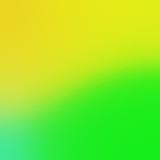

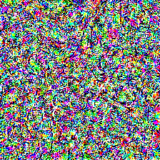

In [39]:
from PIL import Image, ImageOps
import numpy as np
import torch
import torchvision.transforms.functional as TF


# ---------- helper: load learned patch (tensor in memory or PNG) ----------
def load_learned_patch_as_pil(target_size=None):
    # If a torch tensor `learned_patch` exists in the notebook, use that
    try:
        learned_patch  # reference to see if it exists
        # learned_patch expected shape: (C, H, W) in [0,1] or (1,C,H,W)
        t = learned_patch.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        # convert to HxW x C [0..255] PIL
        pil = TF.to_pil_image(t.clamp(0, 1))
        if target_size:
            pil = pil.resize(target_size, Image.BILINEAR)
        return pil
    except NameError:
        # fallback to PNG file created earlier
        for fname in "learned_patch.png":
            try:
                pil = Image.open(fname).convert("RGB")
                if target_size:
                    pil = pil.resize(target_size, Image.BILINEAR)
                return pil
            except FileNotFoundError:
                continue
        raise FileNotFoundError(
            "learned_patch not found in memory or on disk (looked for learned_patch.png)."
        )


# ---------- load direct_toaster_patch.png ----------
def load_direct_patch_as_pil(target_size=None):
    # try a few possible filenames you created earlier
    candidates = ["direct_toaster_patch.png"]
    for fname in candidates:
        try:
            pil = Image.open(fname).convert("RGB")
            if target_size:
                pil = pil.resize(target_size, Image.BILINEAR)
            return pil
        except FileNotFoundError:
            continue
    raise FileNotFoundError("direct_toaster_patch.* not found in cwd. Check file name.")


# ---------- get base size (we'll make combined patches same size) ----------
# use the learned patch's size as canonical
canon = None
try:
    # try to infer a canonical size from learned_patch tensor
    if "learned_patch" in globals():
        t = learned_patch.detach().cpu()
        if t.ndim == 4:
            t = t[0]
        H, W = int(t.shape[1]), int(t.shape[2])
        canon = (W, H)
except Exception:
    pass

# fallback canonical size if none
if canon is None:
    canon = (224, 224)

print("canonical patch size:", canon)

# Load both patches as PIL (resized to canonical)
learned_pil = load_learned_patch_as_pil(target_size=canon)
direct_pil = load_direct_patch_as_pil(target_size=canon)

# quick display in notebook (if you want)
display(learned_pil)
display(direct_pil)

Saved: combined_blend_50.png


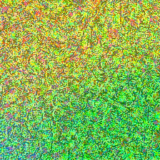

Saved: combined_toaster70.png


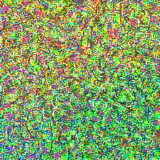

Saved: combined_half_lr.png


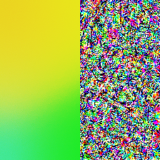

Saved: combined_checker.png


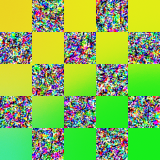

Saved: combined_multiply.png


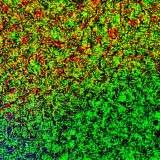

In [40]:
def save_and_show(pil, name):
    pil.save(name)
    print("Saved:", name)
    display(pil)


W, H = canon

# 1) Weighted alpha blend (50/50)
alpha = 0.5
blend_50 = Image.blend(learned_pil, direct_pil, alpha)
save_and_show(blend_50, "combined_blend_50.png")

# 2) Strong toaster-dominant (70% toaster)
blend_toaster70 = Image.blend(learned_pil, direct_pil, 0.7)
save_and_show(blend_toaster70, "combined_toaster70.png")

# 3) Left half learned, right half toaster
half = Image.new("RGB", (W, H))
left = learned_pil.crop((0, 0, W // 2, H))
right = direct_pil.crop((W // 2, 0, W, H))
half.paste(left, (0, 0))
half.paste(right, (W // 2, 0))
save_and_show(half, "combined_half_lr.png")

# 4) Checkerboard mix (small squares alternate)
checker = Image.new("RGB", (W, H))
box = 32  # tile size; change if you want
for y in range(0, H, box):
    for x in range(0, W, box):
        use = learned_pil if ((x // box + y // box) % 2 == 0) else direct_pil
        tile = use.crop((x, y, min(x + box, W), min(y + box, H)))
        checker.paste(tile, (x, y))
save_and_show(checker, "combined_checker.png")

# 5) Multiply blend (per-channel multiply -> darker textured)
np_a = np.array(learned_pil).astype(np.float32) / 255.0
np_b = np.array(direct_pil).astype(np.float32) / 255.0
np_mul = np_a * np_b
mul_pil = Image.fromarray(np.uint8(np.clip(np_mul * 255.0, 0, 255)))
save_and_show(mul_pil, "combined_multiply.png")